# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import MaxPooling2D, Conv2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import he_uniform, zeros
from tensorflow.keras.regularizers import l2
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline

![SVHN overview image](svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [16]:
# Run this cell to load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [17]:
x_train = np.moveaxis(train['X'], -1, 0) # use moveaxis to reshape matlab array 
y_train = np.array(train['y'])
x_test = np.moveaxis(test['X'], -1, 0) 
y_test = np.array(test['y'])
y_train[y_train[:,0] == 10] = 0
y_test[y_test[:,0] == 10] = 0

x_train = x_train/255. # normalizing
x_test = x_test/255.

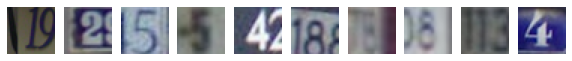

In [18]:
n1 = np.random.randint(1000) # random start position for 10 photos
fig, ax = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    ax[i].set_axis_off()
    ax[i].imshow(x_train[n1 * i])

In [19]:
x_train = x_train.mean(axis=3, keepdims=True) # make images gray
x_test = x_test.mean(axis=3, keepdims=True)

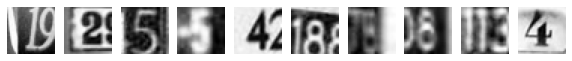

In [21]:
fig, ax = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    image = x_train[n1 * i].squeeze()
    ax[i].set_axis_off()
    ax[i].imshow(image, cmap='Greys')

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [22]:
# callbacks 

def get_checkpoint_callback(name):
    checkpoint_path = f'checkpoint_{name}/best'
    checkpoint = ModelCheckpoint(checkpoint_path, frequency='epoch', save_best_only=True)
    return checkpoint

def get_early_stoping():
    return EarlyStopping(monitor='val_loss', patience=10, verbose=0)

def reduce_lr(coef=0.5):
    return ReduceLROnPlateau(monitor='loss', factor=coef)

In [23]:
def get_MLP_model(input_shape, wd):
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(512, kernel_regularizer=l2(wd), activation='relu'),
        Dense(256, kernel_regularizer=l2(wd), activation='relu'),
        Dense(128, kernel_regularizer=l2(wd), activation='relu'),
        Dense(64, kernel_regularizer=l2(wd), activation='relu'),
        Dense(10, kernel_regularizer=l2(wd), activation='softmax')
    ])
    model.compile(optimizer=Adam(0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [24]:
with tf.device('GPU:0'):
    model = get_MLP_model(x_train[1].shape, 1e-5)
    model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total params: 697,930
Trainable params: 697,930
Non-trainable params: 0
__________________________________________________

In [25]:
with tf.device('GPU:0'):
    history_mlp = model.fit(x_train,
                            y_train,
                            epochs=20, 
                            batch_size=16,
                            validation_split=.15,
                            callbacks=[get_early_stoping(), 
                                       get_checkpoint_callback('mlp'),
                                       reduce_lr()])

Epoch 1/20
3875/3892 [============================>.] - ETA: 0s - loss: 1.8505 - accuracy: 0.3585WARNING:tensorflow:From c:\users\79689\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: checkpoint_mlp\best\assets
3892/3892 [==============================] - 12s 3ms/step - loss: 1.8483 - accuracy: 0.3595 - val_loss: 1.5321 - val_accuracy: 0.4917
Epoch 2/20
3892/3892 [==============================] - 12s 3ms/step - loss: 1.3218 - accuracy: 0.5781 - val_loss: 1.1998 - val_accuracy: 0.6326
Epoch 3/20
3892/3892 [==============================] - 1

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [26]:
def get_CNN_model(input_shape):
    model = Sequential([
        Conv2D(64, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2,2)),
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer=Adam(0.0001),
                  loss=SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

In [27]:
with tf.device('GPU:0'):
    cnn_model = get_CNN_model(x_train[0].shape)
    cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               147584    
_________________________________________________________________
dropout (Dropout)            (None, 128)              

In [28]:
with tf.device('GPU:0'):
    history_cnn = cnn_model.fit(x_train,
                                    y_train,
                                    epochs=20, 
                                    batch_size=16,
                                    validation_split=.15,
                                    callbacks=[get_early_stoping(),
                                               get_checkpoint_callback('cnn'),
                                               reduce_lr()])

Epoch 1/20
3892/3892 [==============================] - 16s 4ms/step - loss: 1.9628 - accuracy: 0.3047 - val_loss: 1.1491 - val_accuracy: 0.6239
Epoch 2/20
3892/3892 [==============================] - 16s 4ms/step - loss: 1.2014 - accuracy: 0.5969 - val_loss: 0.7091 - val_accuracy: 0.7963
Epoch 3/20
3892/3892 [==============================] - 16s 4ms/step - loss: 0.9349 - accuracy: 0.7015 - val_loss: 0.5539 - val_accuracy: 0.8373
Epoch 4/20
3892/3892 [==============================] - 16s 4ms/step - loss: 0.8079 - accuracy: 0.7496 - val_loss: 0.5194 - val_accuracy: 0.8443
Epoch 5/20
3892/3892 [==============================] - 16s 4ms/step - loss: 0.7360 - accuracy: 0.7756 - val_loss: 0.4874 - val_accuracy: 0.8544
Epoch 6/20
3892/3892 [==============================] - 16s 4ms/step - loss: 0.6884 - accuracy: 0.7938 - val_loss: 0.4763 - val_accuracy: 0.8571
Epoch 7/20
3892/3892 [==============================] - 16s 4ms/step - loss: 0.6461 - accuracy: 0.8060 - val_loss: 0.4429 - val_ac

In [34]:
df_cnn = pd.DataFrame(history_cnn.history)
df_mlp = pd.DataFrame(history_mlp.history)

Text(0, 0.5, 'loss')

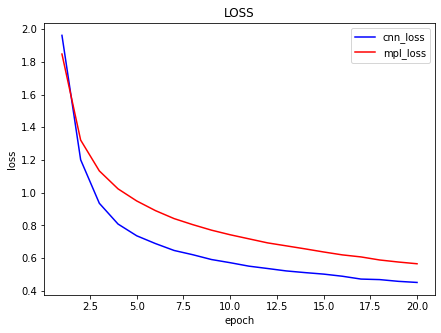

In [57]:
plt.figure(figsize=(7, 5))
plt.plot(range(1, 21), df_cnn['loss'], c='b', label='cnn_loss')
plt.plot(range(1, 21), df_mlp['loss'], c='r', label='mlp_loss')
plt.legend(['cnn_loss', 'mpl_loss'])
plt.title('LOSS')
plt.xlabel('epoch')
plt.ylabel('loss')

Text(0, 0.5, 'accuracy')

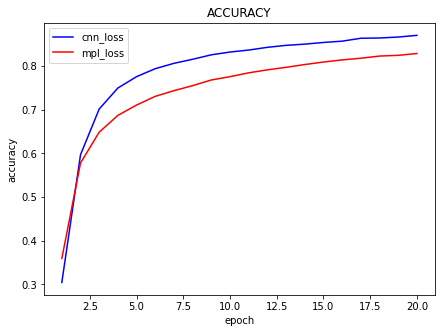

In [58]:
plt.figure(figsize=(7, 5))
plt.plot(range(1, 21), df_cnn['accuracy'], c='b', label='cnn_accuracy')
plt.plot(range(1, 21), df_mlp['accuracy'], c='r', label='mlp_accuracy')
plt.legend(['cnn_loss', 'mpl_loss'])
plt.title('ACCURACY')
plt.xlabel('epoch')
plt.ylabel('accuracy')

In [59]:
with tf.device('GPU:0'):
    cnn_dict_results = cnn_model.evaluate(x_test, y_test)

814/814 [==============================] - 2s 2ms/step - loss: 0.4210 - accuracy: 0.8786


In [60]:
with tf.device('GPU:0'):
    mlp_dict_results = model.evaluate(x_test, y_test)

814/814 [==============================] - 1s 2ms/step - loss: 0.7169 - accuracy: 0.8001


In [63]:
print('cnn results:\n\tloss:{}\n\tacc:{}'.format(cnn_dict_results[0], cnn_dict_results[1]))
print('mlp results:\n\tloss:{}\n\tacc:{}'.format(mlp_dict_results[0], mlp_dict_results[1]))

cnn results:
	loss:0.421041339635849
	acc:0.8785725235939026
mlp results:
	loss:0.7169337868690491
	acc:0.8000922203063965


## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [125]:
#loading models
loaded_mlp = load_model('checkpoint_mlp/best')
loaded_cnn = load_model('checkpoint_cnn/best')

In [126]:
#selecting 5 random pictures with tags
random_set_x = []
random_set_y = []
for i in range(5):
    el = np.random.randint(len(x_test))
    random_set_x.append(x_test[el])
    random_set_y.append(y_test[el][0])

random_set_x = np.array(random_set_x)

In [127]:
with tf.device('GPU:0'):
    results = loaded_mlp.predict(random_set_x)

In [128]:
with tf.device('GPU:0'):
    results_cnn = loaded_mlp.predict(random_set_x)

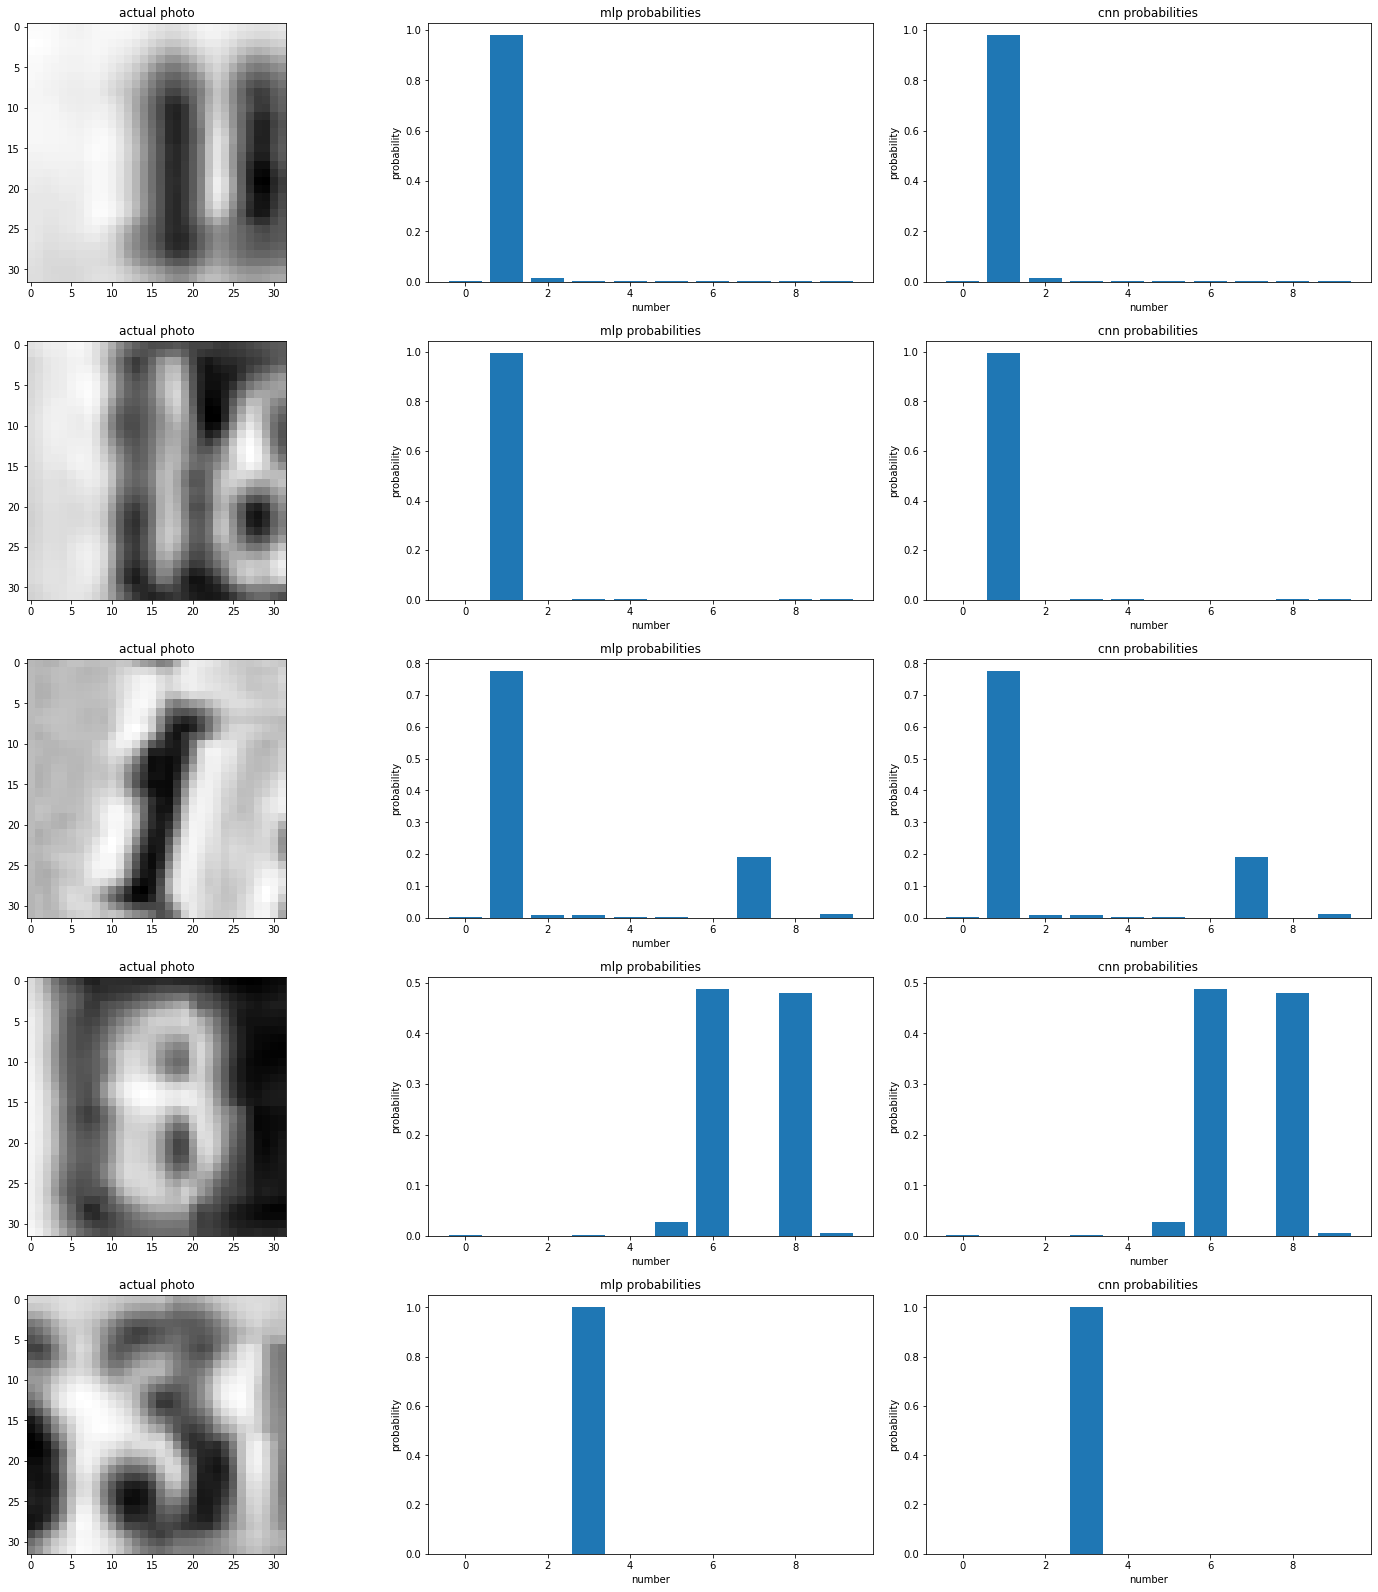

In [129]:
fig, ax = plt.subplots(5, 3, figsize=(20, 22), constrained_layout=True)
for i in range(5):
    image = random_set_x[i].squeeze()
    ax[i, 0].title.set_text('actual photo')
    ax[i, 0].imshow(image, cmap='Greys')
    
    ax[i, 1].title.set_text('mlp probabilities')
    ax[i, 1].bar(x=range(10), height=results[i])
    ax[i, 1].set_xlabel('number')
    ax[i, 1].set_ylabel('probability')
    
    ax[i, 2].title.set_text('cnn probabilities')
    ax[i, 2].bar(x=range(10), height=results_cnn[i])
    ax[i, 2].set_xlabel('number')
    ax[i, 2].set_ylabel('probability')

In [137]:
#comparing actual results
cnn_final_results = results_cnn.argmax(axis=1)
mlp_final_results = results.argmax(axis=1)
final_table = np.array([random_set_y, mlp_final_results, cnn_final_results]).T
final_res = pd.DataFrame(data=final_table, columns=['actual_res', 'mlp_res', 'cnn_res'])
final_res

,actual_res,mlp_res,cnn_res
0,1,1,1
1,1,1,1
2,1,1,1
3,8,6,6
4,3,3,3


As you can see both models misinterpred number 8. Actual result is 8 but they "think" its 6. At the same time both models are not very confidence with that result ( you can see that on bar plots) Probabilities of 8 and 6 are pretty close, so we need to train our models to get better results. Thanks.